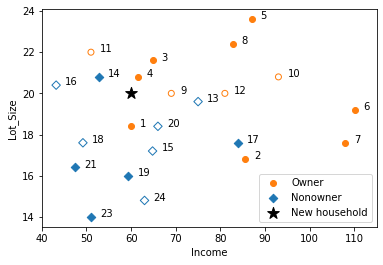

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the dataset
url = "https://raw.githubusercontent.com/reisanar/datasets/master/RidingMowers.csv"
mower_df = pd.read_csv(url)
mower_df['Number'] = mower_df.index + 1

# Split the data into training and validation sets
trainData, validData = train_test_split(mower_df, test_size=0.4, random_state=26)

# New household data
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])

# Scatter plot function
def plotDataset(ax, data, showLabel=True, **kwargs):
    # Plot Owner data points
    subset = data.loc[data['Ownership'] == 'Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o',
               label='Owner' if showLabel else None, color='C1', **kwargs)
    # Plot Nonowner data points
    subset = data.loc[data['Ownership'] == 'Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D',
               label='Nonowner' if showLabel else None, color='C0', **kwargs)
    # Set axis labels
    plt.xlabel('Income')
    plt.ylabel('Lot_Size')
    # Annotate points
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

# Create the plot
fig, ax = plt.subplots()

# Plot the training data
plotDataset(ax, trainData)

# Plot the validation data
plotDataset(ax, validData, showLabel=False, facecolors='none')

# Plot the new household
ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*',
           label='New household', color='black', s=150)

# Set axis labels
plt.xlabel('Income')
plt.ylabel('Lot_Size')

# Adjust axis limits
ax.set_xlim(40, 115)

# Add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc=4)

# Show the plot
plt.show()

In [3]:
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors

# Define predictors and outcome
predictors = ['Income', 'Lot_Size']

# Initialize normalized training, validation, and complete data frames
# Use the training data to learn the transformation
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])  # Note the use of array of column names

# Transform the full dataset
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]),
                                    columns=['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis=1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold),
                                columns=['zIncome', 'zLot_Size'])

# Use NearestNeighbors from scikit-learn to compute nearest neighbors
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm.iloc[:, 0:2])
distances, indices = knn.kneighbors(newHouseholdNorm)

# Output the nearest neighbors
trainNorm.iloc[indices[0], :]

,zIncome,zLot_Size,Ownership,Number
3,-0.409776,0.743358,Owner,4
13,-0.804953,0.743358,Nonowner,14
0,-0.477910,-0.174908,Owner,1


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Split the normalized data into features (X) and target (y)
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# Train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# Convert results to a pandas DataFrame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.6
1    2       0.7
2    3       0.8
3    4       0.9
4    5       0.7
5    6       0.9
6    7       0.9
7    8       0.9
8    9       0.9
9   10       0.8
10  11       0.8
11  12       0.9
12  13       0.4
13  14       0.4
